In [1]:
from hydra import initialize, compose
import json
from rdkit import Chem
from pathlib import Path
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.mapping import rc_to_nest
from IPython.display import SVG
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
with initialize(version_base=None, config_path="./conf/filepaths"):
    filepaths = compose(config_name="filepaths")

In [3]:
entries = {}
for i in range(0, 11):
    with open(Path(filepaths.raw_mcsa) / f"entries_{i}.json", "r") as f:
        entries = {**entries, **json.load(f)}

mech_ct = 0
detailed_ct = 0
for id, entry in entries.items():
    mechanisms = entry['reaction']['mechanisms']
    if mechanisms is None:
        continue

    for mech in mechanisms:
        mech_ct += 1
        if mech['is_detailed']:
            detailed_ct += 1

print(f"Total number of mechanisms: {mech_ct}")
print(f"Number of detailed mechanisms: {detailed_ct} ({detailed_ct/mech_ct*100:.2f}%)")
print(f"Total number of entries: {len(entries)}")


Total number of mechanisms: 1166
Number of detailed mechanisms: 887 (76.07%)
Total number of entries: 1003


In [4]:
mech_df = pd.read_csv(Path(filepaths.interim_data) / 'mcsa' / 'mech_labeled_reactions.csv', sep=",")
mech_df['mech_atoms'] = mech_df['mech_atoms'].apply(lambda x: rc_to_nest(x))
n_unique = len(set(mech_df[["entry_id", "mechanism_id"]].apply(tuple, axis=1)))
print(f"{n_unique/detailed_ct*100:.2f}% of detailed mechanisms have been processed")
mech_df.head(10)

63.13% of detailed mechanisms have been processed


,entry_id,mechanism_id,smarts,mech_atoms,enzyme_name,uniprot_id,ec
0,1,1,[NH3+:32][CH:31]([CH2:33][CH2:37][C:34](=[O:35...,"(((28, 29, 30, 31),), ((),))",glutamate racemase,P56868,5.1.1.3
1,1,1,[NH3+:32][CH:31]([CH2:33][CH2:37][C:34](=[O:35...,"(((28, 29, 30, 31),), ((),))",glutamate racemase,P56868,5.1.1.3
2,2,2,[OH2:60].[*:39][C:38](=[O:40])[NH:36][CH:23]1[...,"(((60,), (24, 25, 27)), ((),))",beta-lactamase (Class A),P62593,3.5.2.6
3,2,1,[OH2:61].[*:55][C:54](=[O:56])[NH:52][CH:39]1[...,"(((61,), (40, 41, 43)), ((),))",beta-lactamase (Class A),P62593,3.5.2.6
4,4,2,[Cu+2:75].[O:57]=[N:58][OH:59]>>O.[N]=O.[Cu+],"(((), (57, 58, 59)), ((),))",nitrite reductase (copper type),P25006,1.7.2.1
5,4,1,[Cu+2:65].[O:46]=[N:47][OH:48]>>O.[N]=O.[Cu+],"(((65,), (46, 47, 48)), ((),))",nitrite reductase (copper type),P25006,1.7.2.1
6,6,1,[NH3+:76][CH:77]([CH2:78][CH2:79][C:80](=[O:81...,"(((115, 104), (33, 35, 37, 39)), ((),))",glutathione-disulfide reductase,P00390,1.8.1.7
7,7,2,[NH2:61][C:59](=[O:60])[c:56]1[cH:58][cH:57][c...,"(((52, 54, 56, 58), (76, 77, 80, 82, 81, 83)),...",isocitrate dehydrogenase (NADP+),P08200,1.1.1.42
8,7,1,[NH2:61][C:59](=[O:60])[c:56]1[cH:58][cH:57][c...,"(((52, 54, 56, 58), (76, 77, 80, 82, 81, 83)),...",isocitrate dehydrogenase (NADP+),P08200,1.1.1.42
9,7,3,[NH2:61][C:59](=[O:60])[c:56]1[cH:58][cH:57][c...,"(((52, 54, 56, 58), (76, 77, 80, 82, 81, 83)),...",isocitrate dehydrogenase (NADP+),P08200,1.1.1.42


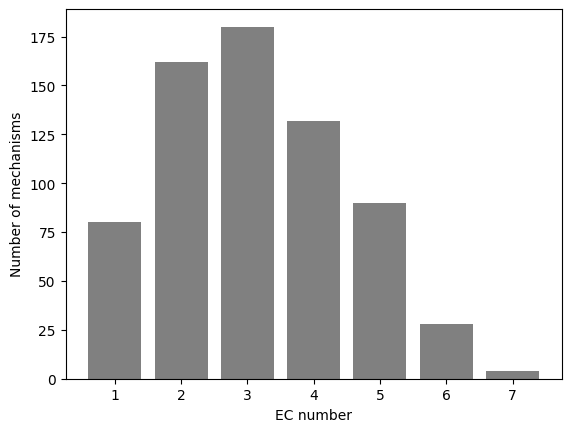

In [5]:
ecs = []
n_digits = 1
for eid in mech_df['entry_id']:
    ecs.append(entries[str(eid)]['reaction']['ec'])

ec_trunc = [elt[:n_digits] for elt in ecs]
ec_counts = Counter(ec_trunc)
ec_counts = sorted(ec_counts.items(), key=lambda x: x[0])

fig, ax = plt.subplots()
x = [i for i in range(len(ec_counts))]
ax.bar(x, [elt[1] for elt in ec_counts], color='gray')
ax.set_xticks(x)
ax.set_xticklabels([elt[0] for elt in ec_counts])
ax.set_xlabel('EC number')
ax.set_ylabel('Number of mechanisms')
plt.show()

In [6]:
def display_mech_labeled_rxn(entry_id: int, de_am: bool = True):
    sma2mol = lambda x : Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmarts(x)))

    # Get the reaction
    smarts = mech_df.loc[mech_df['entry_id'] == entry_id, 'smarts'].iloc[0]

    these_mechs = mech_df.loc[mech_df['entry_id'] == entry_id]
    for _, row in these_mechs.iterrows():
        print(f"Mechanism: #{row['mechanism_id']}")
        smarts = row['smarts']
        lhs = [sma2mol(elt) for elt in smarts.split('>>')[0].split('.')]
        mech_atom_map_nums = row['mech_atoms'][0]

        # Get atoms involved in the reaction
        involved_atoms = []
        for ams, mol in zip(mech_atom_map_nums, lhs):
            involved_atoms.append([atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomMapNum() in ams])

        
        if de_am:
            for mol in lhs:
                for atom in mol.GetAtoms():
                    atom.SetAtomMapNum(0)

            smarts = '.'.join([Chem.MolToSmiles(mol) for mol in lhs]) + '>>' + smarts.split('>>')[1]
        
        # Display
        display(SVG(draw_reaction(smarts, sub_img_size=(150, 100))))
        for i, rct in enumerate(lhs):
            display(SVG(draw_molecule(rct, size=(300, 200), highlight_atoms=involved_atoms[i], draw_options={"addAtomIndices": False})))

Mechanism: #1


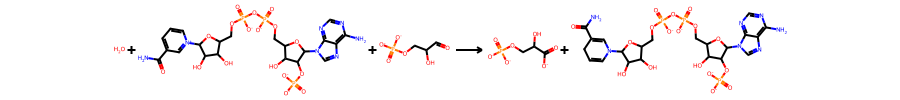

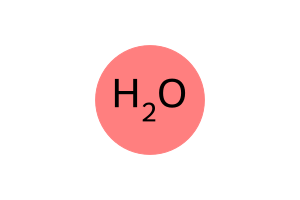

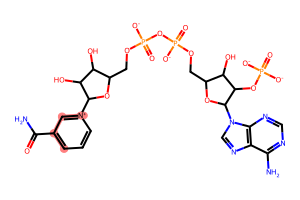

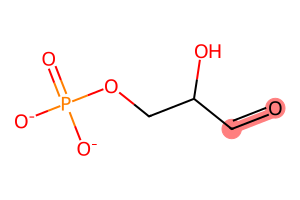

In [7]:
display_mech_labeled_rxn(711)

Mechanism: #1


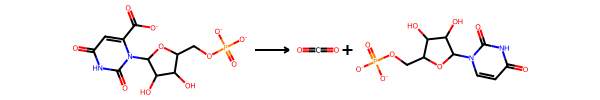

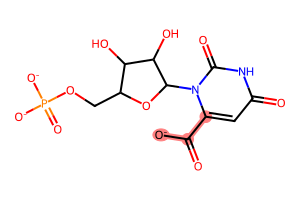

Mechanism: #3


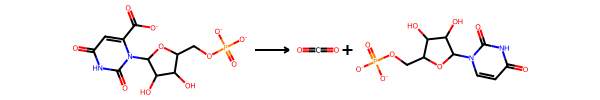

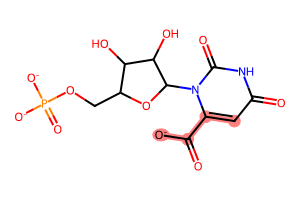

Mechanism: #2


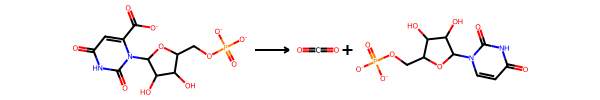

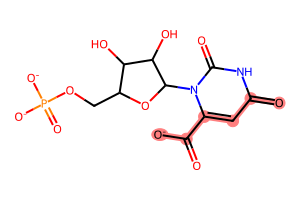

In [8]:
display_mech_labeled_rxn(50)

Mechanism: #1


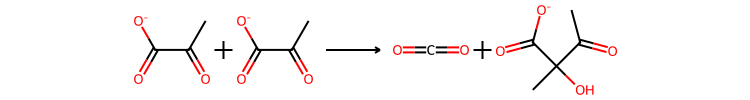

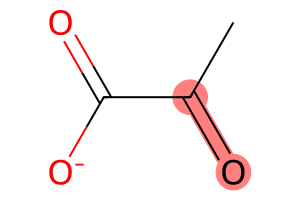

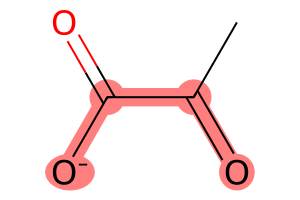

In [9]:
display_mech_labeled_rxn(722)

Mechanism: #1


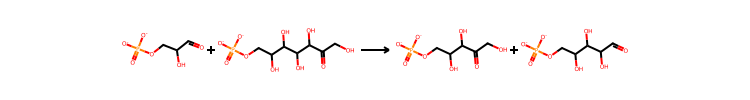

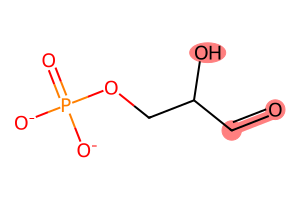

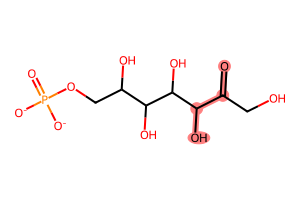

In [10]:
display_mech_labeled_rxn(219)

Mechanism: #2


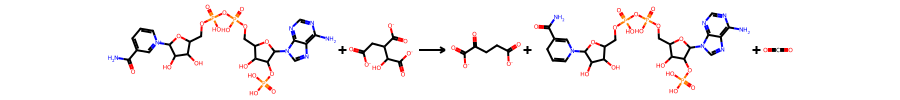

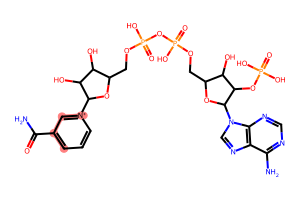

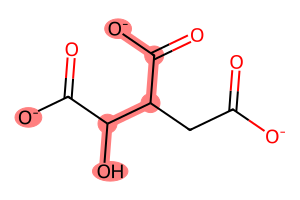

Mechanism: #1


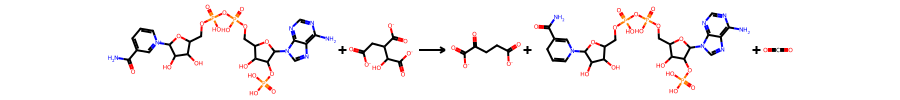

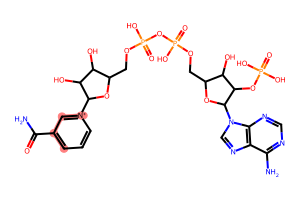

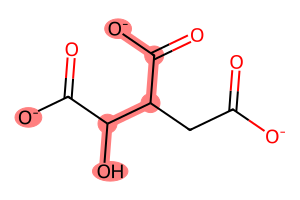

Mechanism: #3


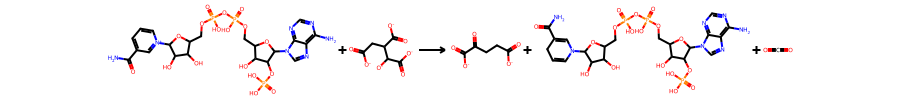

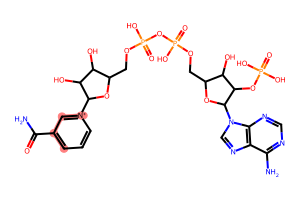

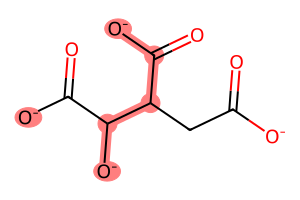

In [11]:
display_mech_labeled_rxn(7)

Mechanism: #2


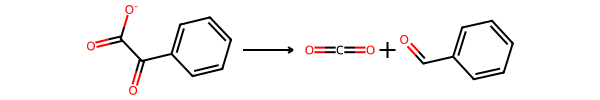

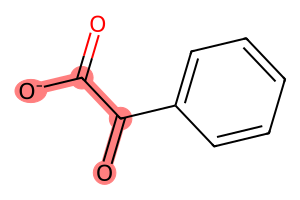

Mechanism: #3


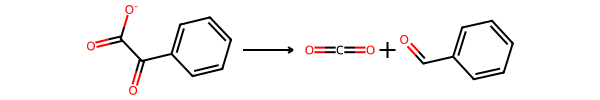

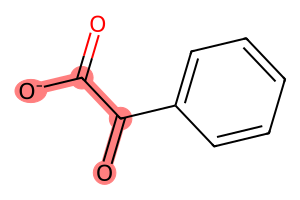

Mechanism: #1


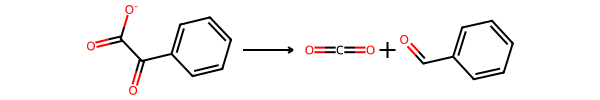

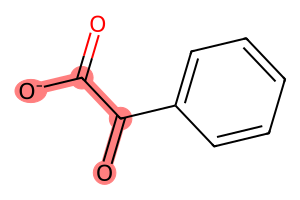

In [12]:
display_mech_labeled_rxn(220)

Mechanism: #1


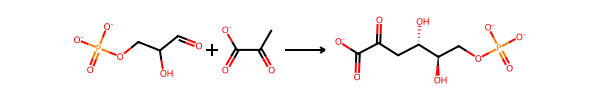

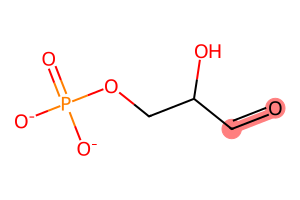

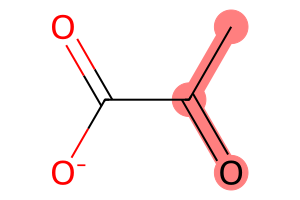

In [13]:
display_mech_labeled_rxn(550)

Mechanism: #1


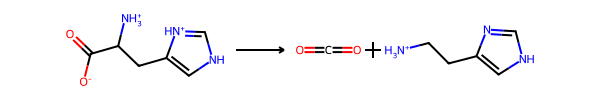

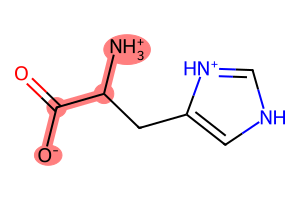

In [14]:
display_mech_labeled_rxn(49)

In [15]:
mm = pd.read_parquet(
    Path(filepaths.processed_data) / "mcsa" / "mapped_mech_labeled_reactions.parquet"
)
mm.head()

,entry_id,mechanism_id,smarts,am_smarts,rule,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec,rule_id
0,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:5][CH:1]([CH2:3][CH2:2][C:4](=[O:9])[OH:1...,[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[#6:1]-[#6:3]-[#6...,"1,2,3,4>>0,1,2,3","1,7,8,9>>",glutamate racemase,P56868,5.1.1.3,948
1,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:5][CH:1]([CH2:3][CH2:2][C:4](=[O:9])[OH:1...,[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[#6:1]-[#6:3]-[#6...,"1,2,3,4>>0,1,2,3","1,7,8,9>>",glutamate racemase,P56868,5.1.1.3,948
2,2,2,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:10][C:8](=[O:11])[NH:6][CH:4]1[C:2](=[O:5])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"5,7;0>>0,1,2","5,6,7;0>>",beta-lactamase (Class A),P62593,3.5.2.6,496
3,2,1,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:10][C:8](=[O:11])[NH:6][CH:4]1[C:2](=[O:5])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"5,7;0>>0,1,2","5,6,7;0>>",beta-lactamase (Class A),P62593,3.5.2.6,496
4,6,1,NC(CCC(=O)NC(CSSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCC...,[NH2:17][CH:14]([CH2:12][CH2:9][C:6](=[O:10])[...,[#16:1]-[#16:2].[#6:3]1=[#6:4]-[#7:5]-[#6:6]=[...,"9,10;3,4,5,45,46,47>>0;0;0,1,2,3,4,5","9,10;3,4,5,47>>",glutathione-disulfide reductase,P00390,1.8.1.7,146
